# Preprocessing for Sentiment Analysis - Amazon Reviews



> **Note**: This notebook is compatible with both Google Colab and local Jupyter environments. Colab-specific sections are clearly marked.

This notebook outlines the text preprocessing pipeline used for sentiment analysis on the Amazon Reviews dataset. Preprocessing is a critical step in any NLP task, as it transforms raw text into a standardized format suitable for modeling.

Key preprocessing steps include:
- Lowercasing all text
- Removing HTML tags and special characters
- Tokenization using simple whitespace splitting
- Optional removal of stopwords and punctuation
- Rejoining cleaned tokens for downstream vectorization

The cleaned data is saved and used in a separate notebook for TF-IDF vectorization, model training, and evaluation. This modular structure allows for flexible experimentation with different preprocessing strategies.

## Import Libraries

In [1]:
!pip install swifter
!pip install word2number

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/NLP_Projects/Week_1/sentiment-analysis/'
    if os.path.exists(project_path):
        os.chdir(project_path)
        print(f"Changed working directory to: {project_path}")
    else:
        raise FileNotFoundError(f"Project path not found: {project_path}")
else:
    print("Not running in Colab — skipping Drive mount.")

Not running in Colab — skipping Drive mount.


In [3]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import re
import swifter

from word2number import w2n

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rmcnamara4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rmcnamara4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rmcnamara4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rmcnamara4/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rmcnamara4/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and Splitting the Dataset

We begin by loading the Amazon Reviews sentiment dataset, which includes columns for sentiment labels, titles, and review text. Since the review title is not necessary for our task, we drop it and focus on the sentiment and full review content.

We then perform the following splits:
- Use 700,000 examples from the training set to reduce processing time.
- Perform an 80/20 stratified split to create training and validation sets with balanced sentiment classes.

These subsets will be saved and used for preprocessing and model training in subsequent steps.

In [5]:
train_temp = pd.read_csv('../data/train.csv', header = None)
test = pd.read_csv('../data/test.csv', header = None)

train_temp.columns = ['sentiment', 'title', 'review']
test.columns = ['sentiment', 'title', 'review']

train_temp = train_temp.drop(columns = 'title')
test = test.drop(columns = 'title')

In [6]:
train, _ = train_test_split(train_temp, train_size = 700_000, random_state = 432, stratify = train_temp.sentiment)
train, val = train_test_split(train, train_size = 0.8, random_state = 432, stratify = train.sentiment)

## EDA

### Descriptive Statistics

Before diving into text preprocessing, we inspect the basic structure of the dataset:

- **Shape** of each split (train, validation, test) to confirm sizes.
- **Missing values** in each split to ensure data completeness.
- **Class distribution** of the `sentiment` labels to verify class balance across splits.

This helps us validate that the dataset was split correctly and that no data cleaning is needed for missing entries or label imbalances.

In [ ]:
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

train shape: (560000, 2)
val shape: (140000, 2)
test shape: (400000, 2)


In [ ]:
print('train missing values:')
print(train.isna().sum())
print()
print('val missing values:')
print(val.isna().sum())
print()
print('test missing values:')
print(test.isna().sum())

train missing values:
sentiment    0
review       0
dtype: int64

val missing values:
sentiment    0
review       0
dtype: int64

test missing values:
sentiment    0
review       0
dtype: int64


In [ ]:
print('Train label counts:')
print(train.sentiment.value_counts(normalize = True))
print()
print('Val label counts:')
print(val.sentiment.value_counts(normalize = True))
print()
print('Test label counts:')
print(test.sentiment.value_counts(normalize = True))

Train label counts:
sentiment
2    0.5
1    0.5
Name: proportion, dtype: float64

Val label counts:
sentiment
2    0.5
1    0.5
Name: proportion, dtype: float64

Test label counts:
sentiment
2    0.5
1    0.5
Name: proportion, dtype: float64


We have perfectly balanced classes in this dataset, so there is no need to worry about resampling or minority class weighting.

### Visualizations

To better understand the structure and variability in the dataset, we visualize the distribution of review lengths:

- **Character Lengths**: We compute and plot the character length distribution of reviews in the train, validation, and test sets. This helps identify outliers and informs potential max length thresholds for modeling.
- **Token Lengths**: We also calculate and visualize the number of tokens (words) per review across all splits. These insights guide preprocessing choices like padding, truncation, and sequence length limits in downstream modeling.

All histograms show percentage distributions for better comparability across dataset splits.

train review character lengths:
count    560000.000000
mean        404.677050
std         234.119224
min          12.000000
25%         207.000000
50%         356.000000
75%         566.000000
max        1008.000000
Name: review, dtype: float64

val review character lengths:
count    140000.000000
mean        405.328307
std         234.325974
min          25.000000
25%         207.000000
50%         356.000000
75%         567.000000
max        1008.000000
Name: review, dtype: float64

test review character lengths:
count    400000.000000
mean        404.900197
std         234.109867
min          15.000000
25%         207.000000
50%         356.000000
75%         565.000000
max        1009.000000
Name: review, dtype: float64


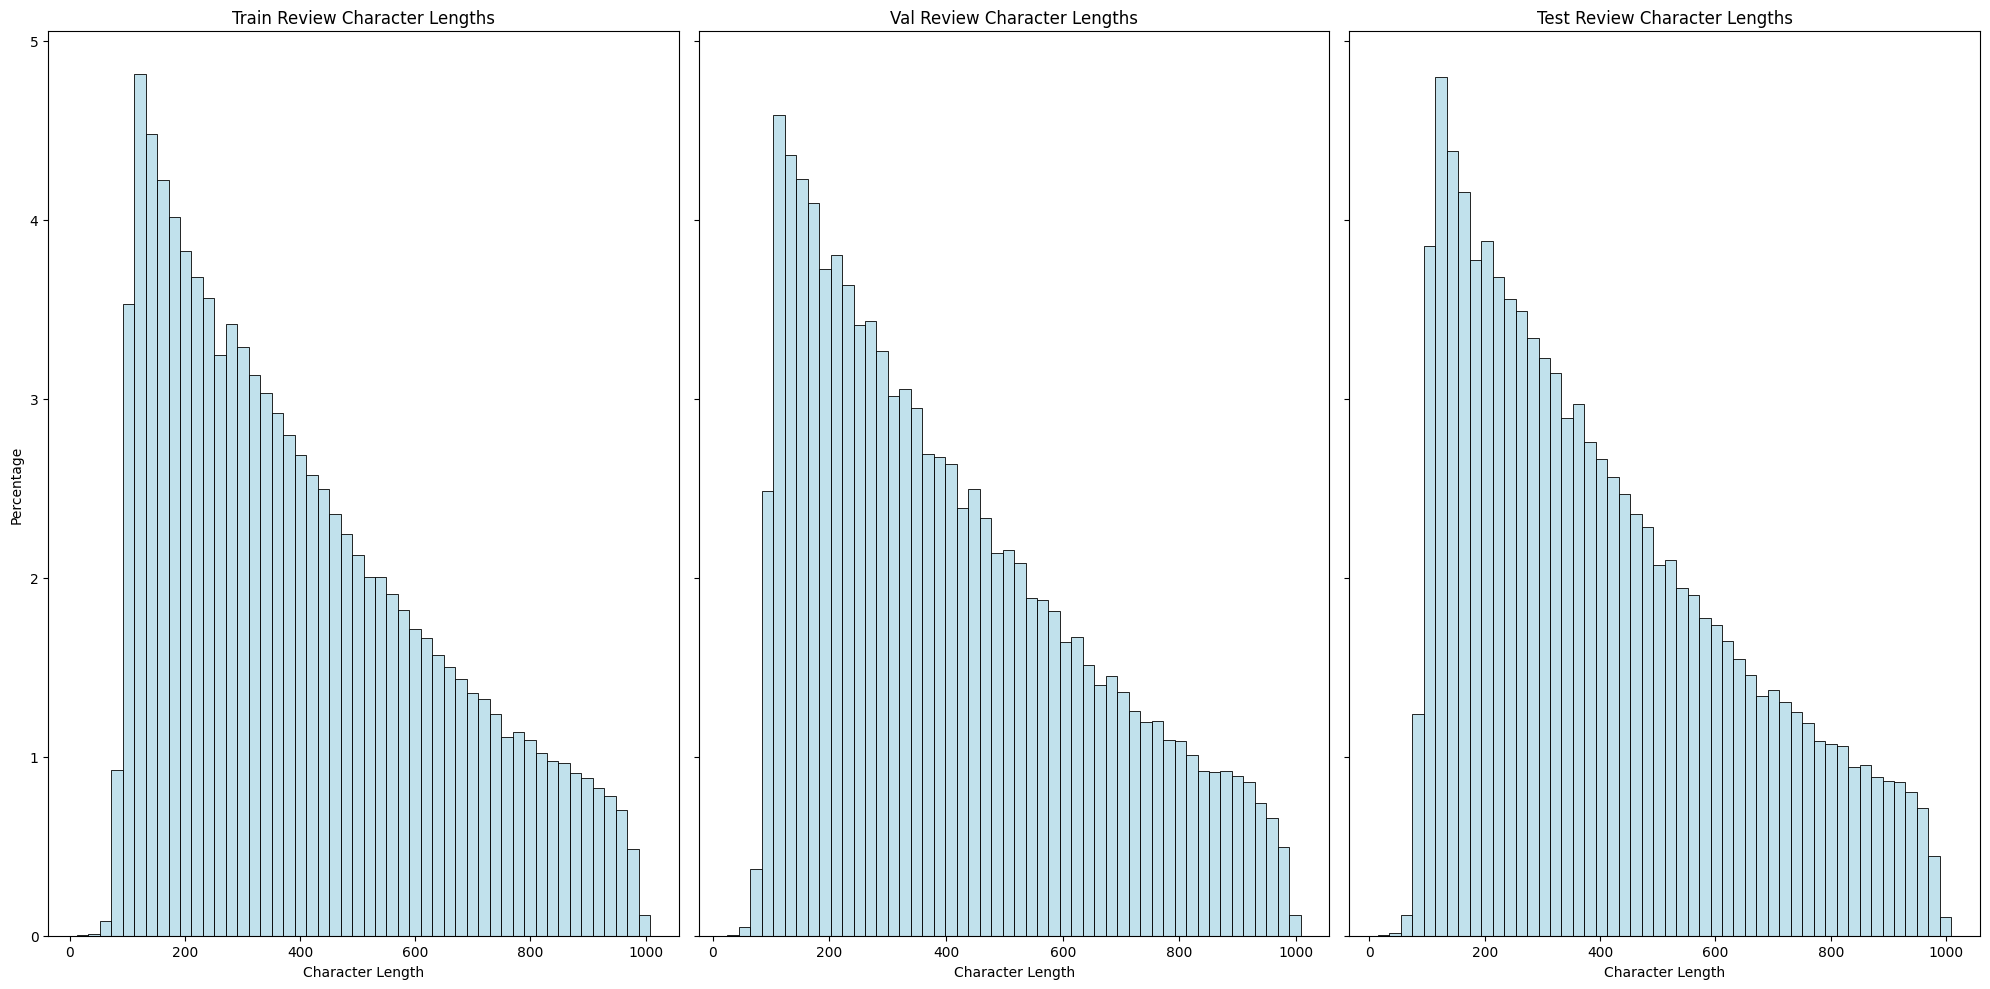

In [ ]:
train_character_lens = train['review'].apply(len)
print('train review character lengths:')
print(train_character_lens.describe())
print()
val_character_lens = val['review'].apply(len)
print('val review character lengths:')
print(val_character_lens.describe())
print()
test_character_lens = test['review'].apply(len)
print('test review character lengths:')
print(test_character_lens.describe())

fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 10), sharey = True)
sns.histplot(x = train_character_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[0], stat = 'percent')
sns.histplot(x = val_character_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[1], stat = 'percent')
sns.histplot(x = test_character_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[2], stat = 'percent')

axes[0].set_title('Train Review Character Lengths')
axes[1].set_title('Val Review Character Lengths')
axes[2].set_title('Test Review Character Lengths')

axes[0].set_xlabel('Character Length')
axes[1].set_xlabel('Character Length')
axes[2].set_xlabel('Character Length')

axes[0].set_ylabel('Percentage')

plt.tight_layout()

plt.show()

Pandas Apply:   0%|          | 0/560000 [00:00<?, ?it/s]

train review token lengths:
count    560000.000000
mean         74.090934
std          42.286954
min           1.000000
25%          38.000000
50%          66.000000
75%         103.000000
max         240.000000
Name: review, dtype: float64



Pandas Apply:   0%|          | 0/140000 [00:00<?, ?it/s]

val review token lengths:
count    140000.000000
mean         74.193771
std          42.317276
min           4.000000
25%          39.000000
50%          66.000000
75%         103.000000
max         209.000000
Name: review, dtype: float64



Pandas Apply:   0%|          | 0/400000 [00:00<?, ?it/s]

test review token lengths:
count    400000.000000
mean         74.106647
std          42.257943
min           2.000000
25%          39.000000
50%          66.000000
75%         103.000000
max         217.000000
Name: review, dtype: float64


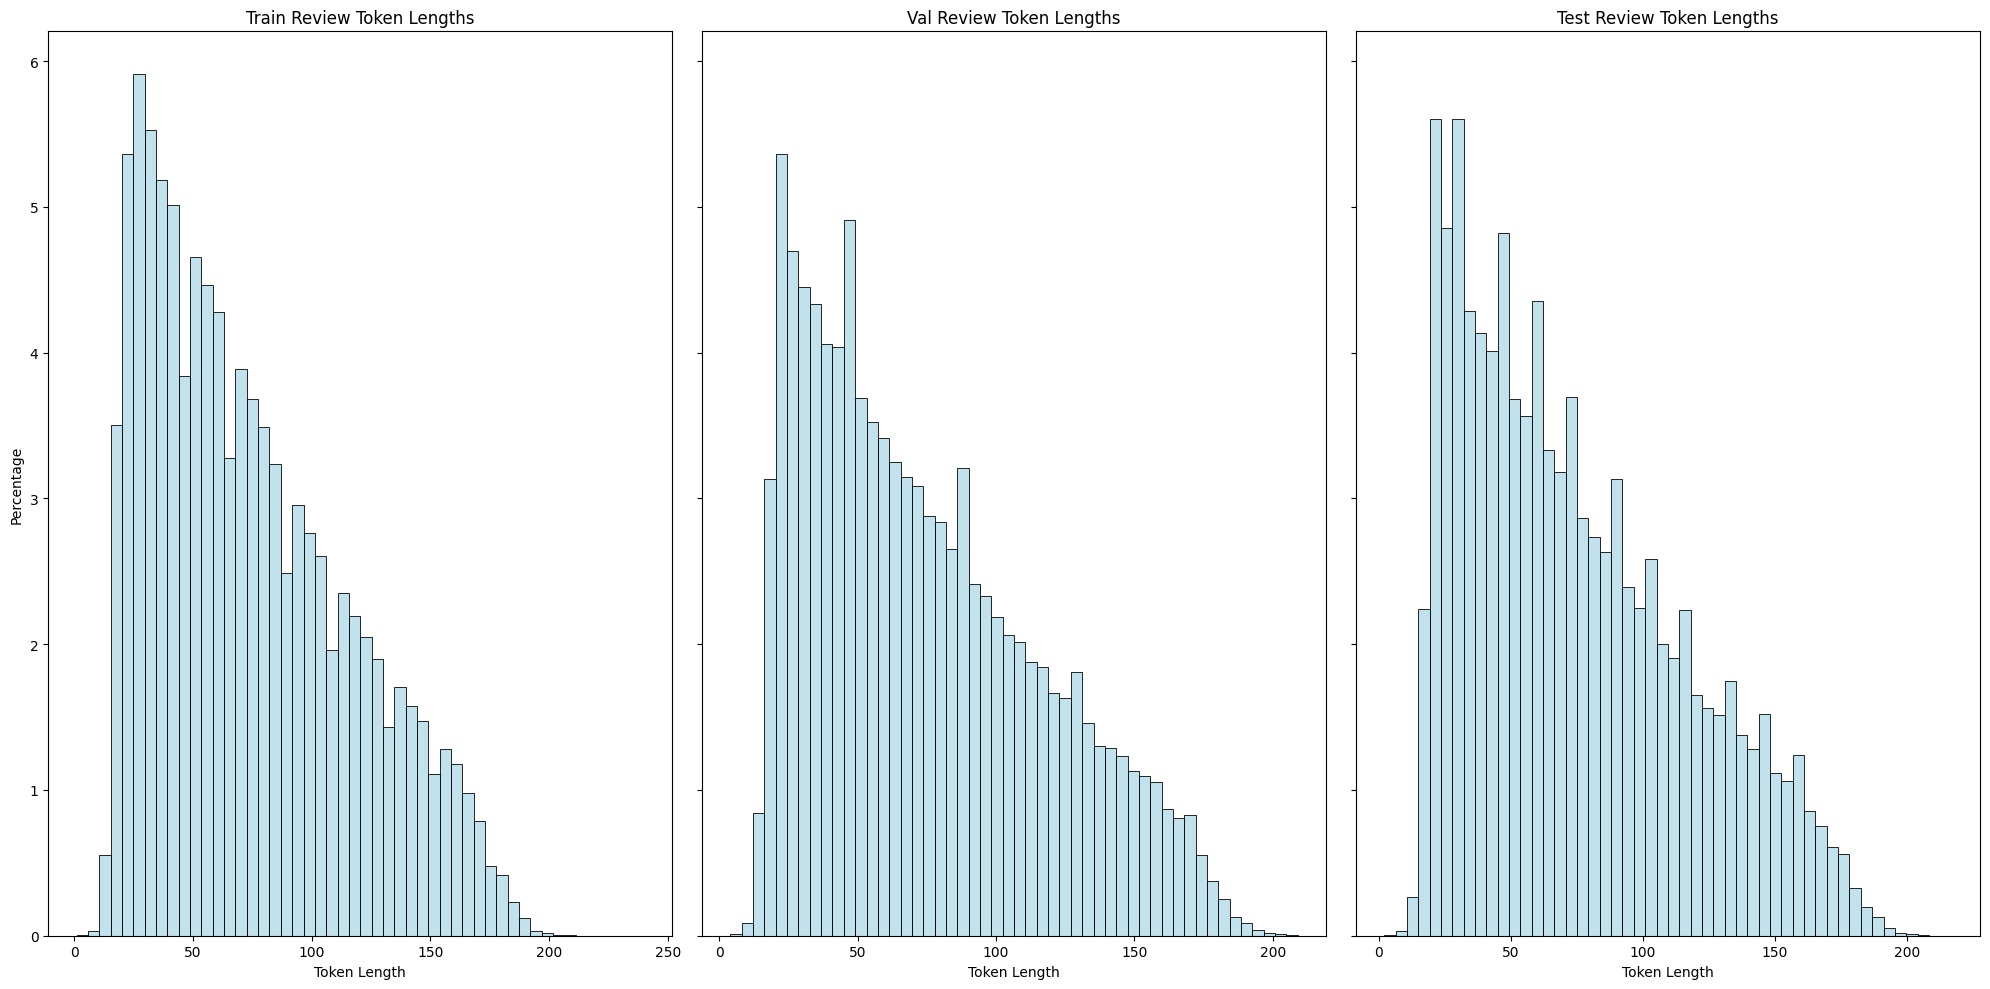

In [ ]:
train_token_lens = train['review'].swifter.apply(lambda x: len(x.split()))
print('train review token lengths:')
print(train_token_lens.describe())
print()
val_token_lens = val['review'].swifter.apply(lambda x: len(x.split()))
print('val review token lengths:')
print(val_token_lens.describe())
print()
test_token_lens = test['review'].swifter.apply(lambda x: len(x.split()))
print('test review token lengths:')
print(test_token_lens.describe())

fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 10), sharey = True)
sns.histplot(x = train_token_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[0], stat = 'percent')
sns.histplot(x = val_token_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[1], stat = 'percent')
sns.histplot(x = test_token_lens, bins = 50, color = 'lightblue', edgecolor = 'black', ax = axes[2], stat = 'percent')

axes[0].set_title('Train Review Token Lengths')
axes[1].set_title('Val Review Token Lengths')
axes[2].set_title('Test Review Token Lengths')

axes[0].set_xlabel('Token Length')
axes[1].set_xlabel('Token Length')
axes[2].set_xlabel('Token Length')

axes[0].set_ylabel('Percentage')

plt.tight_layout()


## Preprocessing

This section prepares the dataset for modeling by applying text normalization, token-level cleaning, and exporting processed datasets for both NLTK and spaCy pipelines.

### Key Preprocessing Steps:
- **Number Replacement**: All numbers—both digit-based (e.g. `123`) and written (e.g. `twelve`)—are replaced with a placeholder token `<NUM>` to reduce vocabulary sparsity while preserving numeric context.
- **NLTK Preprocessing**:
  - Lowercase all text.
  - Remove punctuation using regex.
  - Tokenize with `word_tokenize`.
  - Remove English stopwords.
  - Lemmatize each token using WordNet.
- **spaCy Preprocessing**:
  - Uses `nlp.pipe` for efficient batch processing.
  - Filters out stopwords and non-alphabetic tokens.
  - Applies lemmatization using spaCy’s pipeline.

In [ ]:
def replace_numbers(text):
  """
  Replaces all numeric digits and written numbers in a text string with the <NUM> token.

  Args:
      text (str): A string of text to process.

  Returns:
      str: The input text with standalone digits and number words replaced by <NUM>.

  Notes:
      - Uses regex to detect digit-based numbers (e.g., "123").
      - Uses `word2number` to identify written numbers (e.g., "twenty").
      - Any word that fails both checks remains unchanged.
  """
  words = text.split()
  converted_words = []
  for word in words:
    if re.match(r'\b\d+\b', word):
      converted_words.append('<NUM>')
    else:
      try:
        _ = w2n.word_to_num(word)
        converted_words.append('<NUM>')
      except:
        converted_words.append(word)
  return ' '.join(converted_words)


def replace_numbers_batch(texts):
    """
    Replaces all numeric digits and written numbers with the <NUM> token in a batch of text strings.

    Args:
        texts (List[str]): A list of text strings to process.

    Returns:
        List[str]: A list of processed text strings with numbers replaced by <NUM>.

    Notes:
        - Applies lowercase transformation before processing.
        - Matches digit-based numbers using regex.
        - Converts written numbers (e.g., "five", "twenty") using `word2number`.
        - If conversion fails, retains the original word.
        - Handles unexpected cases by printing the problematic word (for debugging).
    """
    processed_texts = []

    for text in texts:
        words = text.lower().split()
        converted_words = []
        for word in words:
            if re.match(r"\b\d+\b", word):  # Match numeric digits
                converted_words.append("<NUM>")
            else:
                try:
                    _ = w2n.word_to_num(word)  # Convert written number
                    converted_words.append("<NUM>")
                except ValueError:
                    converted_words.append(word)
                except IndexError:
                    print(f'Problematic word: {word}')
                    converted_words.append(word)
        processed_texts.append(" ".join(converted_words))

    return processed_texts


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_nltk(text):
  """
  Applies standard NLP preprocessing steps using NLTK for a single text string.

  Args:
      text (str): The raw input text to preprocess.

  Returns:
      str: The preprocessed text with normalized tokens.

  Steps:
      - Replaces all numeric digits and written numbers with the <NUM> token.
      - Converts text to lowercase for uniformity.
      - Removes punctuation and non-word characters.
      - Tokenizes the text into individual words using NLTK's tokenizer.
      - Removes stopwords from the token list.
      - Applies lemmatization to reduce words to their base form.
      - Returns the cleaned text as a single space-joined string.
  """
  lemmatizer = WordNetLemmatizer()
  text = replace_numbers(text)
  text = text.lower()
  text = re.sub(r"[^\w\s]", "", text)
  tokens = word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return ' '.join(tokens)

def preprocess_spacy(texts):
  """
  Applies NLP preprocessing to a batch of text documents using spaCy.

  Args:
      texts (List[str]): A list of raw text strings to preprocess.

  Returns:
      List[str]: A list of cleaned and lemmatized text strings.

  Steps:
      - Replaces numeric digits and written numbers with the <NUM> token.
      - Processes texts in parallel using spaCy's pipeline.
      - For each document:
          - Removes stopwords.
          - Keeps only alphabetic tokens (filters out punctuation/numbers).
          - Applies lemmatization to each remaining token.
      - Returns a list of preprocessed strings, one for each input text.

  Notes:
      - Uses spaCy's efficient `nlp.pipe()` for batching and parallel processing.
      - The `replace_numbers_batch` function should handle both digit and written numbers.
  """
  texts = replace_numbers_batch(texts)
  processed_texts = [
      ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha]) for doc in nlp.pipe(texts, batch_size = 1000, n_process = -1)
  ]
  return processed_texts

In [ ]:
X_train_nltk = train.review.swifter.apply(preprocess_nltk)
X_train_spacy = preprocess_spacy(train.review.tolist())

X_val_nltk = val.review.swifter.apply(preprocess_nltk)
X_val_spacy = preprocess_spacy(val.review.tolist())

X_test_nltk = test.review.swifter.apply(preprocess_nltk)
X_test_spacy = preprocess_spacy(test.review.tolist())

y_train = train.sentiment
y_val = val.sentiment
y_test = test.sentiment

Pandas Apply:   0%|          | 0/560000 [00:00<?, ?it/s]

Problematic word: million-to-one
Problematic word: thousand-and-one
Problematic word: million-and-one


Pandas Apply:   0%|          | 0/140000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/400000 [00:00<?, ?it/s]

### Output:
Two versions of the cleaned dataset are produced:
- **NLTK-based cleaned text** (`X_train_nltk`, `X_val_nltk`, `X_test_nltk`)
- **spaCy-based cleaned text** (`X_train_spacy`, `X_val_spacy`, `X_test_spacy`)

The labels (`y_train`, `y_val`, `y_test`) are also processed and saved, with sentiment values remapped from `{1, 2}` to binary values `{0, 1}`.

In [ ]:
replace_dict = {1: 0, 2: 1}

X_train_nltk.to_csv('../data/X_train_nltk.csv', header = True, index = False)
pd.Series(X_train_spacy).to_csv('../data/X_train_spacy.csv', header = True, index = False)
y_train.replace(replace_dict).to_csv('../data/y_train.csv', header = True, index = False)

X_val_nltk.to_csv('../data/X_val_nltk.csv', header = True, index = False)
pd.Series(X_val_spacy).to_csv('../data/X_val_spacy.csv', header = True, index = False)
y_val.replace(replace_dict).to_csv('../data/y_val.csv', header = True, index = False)

X_test_nltk.to_csv('../data/X_test_nltk.csv', header = True, index = False)
pd.Series(X_test_spacy).to_csv('../data/X_test_spacy.csv', header = True, index = False)
y_test.replace(replace_dict).to_csv('../data/y_test.csv', header = True, index = False)